# Introduction

Currently, one of the most common (and accurate) methods for conducting a Blood
Smear is manually. The goal of this project is to develop a neural network that can classify WBCs from images as part of an eventual effort to automate the procedure without a significant loss in accuracy. By automating this process, we can not only speed it up, but we also reduce the amount of human labor required to conduct a test, thus lowering the overall cost.

The dataset for this project is a collection of ~12,500 images that are 240 x 320. The images contain several RBCs and a single, highlighted WBC. Each WBC falls into one of four categories: Eosinophil, Lymphocyte, Monocyte, or Neutrophil. The dataset can be found on Kaggle [here](https://www.kaggle.com/paultimothymooney/blood-cells). Through accurate classification, accurate proportions of each WBC type could be calculated and checked for normalcy. Additionally, cell images could be further inspected for abnormalities.

# Module Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import time
%matplotlib inline


import warnings  
with warnings.catch_warnings():  
    warnings.filterwarnings("ignore",category=FutureWarning)
    import keras

from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

Using TensorFlow backend.


# Data Exploration

Let's begin by taking a look at an example of each of the four types of WBC we'll be attempting to classify.

In [2]:
def fetch_data(directory, classes, im_size):
    X_train, y_train, X_test, y_test = [],[],[],[]
    wbc_df = pd.DataFrame(columns=['file_name', 'type', 'group'])
    for i, wbc_type in enumerate(classes):
        path = directory + 'TRAIN/' + wbc_type + '/'
        files = os.listdir(path)
        print("Fetching {} Image Files".format(wbc_type.title()))
        time.sleep(0.25)
        for file in tqdm(files):
            image = plt.imread(path + file)
            im_arr = np.array(Image.fromarray(image).resize(size))
            im_arr = im_arr / 255.
            X_train.append(im_arr)
            y_train.append(i+1)
            
            new_row = {'file_name': file,
                       'type': wbc_type, 
                       'group': 'train'}
            wbc_df = wbc_df.append(new_row, ignore_index=True)
            
        path = directory + 'TEST/' + wbc_type + '/'
        files = os.listdir(path)
        for file in tqdm(files):
            image = plt.imread(path + file)
            im_arr = np.array(Image.fromarray(image).resize(size))
            im_arr = im_arr / 255.
            X_test.append(im_arr)
            y_test.append(i+1)
            
            new_row = {'file_name': file,
                       'type': wbc_type,
                       'group': 'test'}
            wbc_df = wbc_df.append(new_row, ignore_index=True)
            
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = to_categorical(y_train, len(classes)+1)
    y_test = to_categorical(y_test, len(classes)+1)
    return X_train, y_train, X_test, y_test, wbc_df
    
# plt.figure(figsize=(10,8))
# df = pd.DataFrame(columns=['file_name', 'type'])
# df['file_name'] = files
# df.fillna(value=wbc_type, inplace=True)
# wbc_df = wbc_df.append(df)
    
# image = load_img(path + files[0])
# plt.subplot(2,2,i+1)
# plt.title(wbc_type)
# plt.axis('off')
# plt.imshow(image)
    
# plt.tight_layout()
# plt.show()

In [3]:
wbc_types = ['EOSINOPHIL', 'NEUTROPHIL', 'LYMPHOCYTE', 'MONOCYTE']
img_rows, img_cols = 90, 120
size = (img_cols, img_rows)

X_train, y_train, X_test, y_test, wbc_df = fetch_data('dataset2-master/images/', wbc_types, size)

Fetching Eosinophil Image Files


100%|███████████████████████████████████████| 623/623 [00:02<00:00, 209.47it/s]


Fetching Neutrophil Image Files


100%|███████████████████████████████████████| 624/624 [00:02<00:00, 211.09it/s]


Fetching Lymphocyte Image Files


100%|███████████████████████████████████████| 620/620 [00:02<00:00, 211.31it/s]


Fetching Monocyte Image Files


100%|███████████████████████████████████████| 620/620 [00:03<00:00, 187.29it/s]


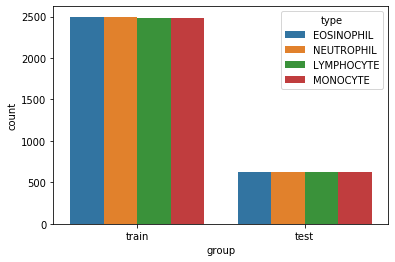

In [4]:
sns.countplot(x='group', hue='type', data=wbc_df)
plt.show()

In [6]:
X_train.shape

(9957, 90, 120, 3)

The images show that each of the four cell types are quite easily visually differentiable. Additionally, we can see from the countplot that our training data is very well balanced with ~2,500 images of each WBC cell type.

# Model Construction

Since the input to be classified are image files, we will be using a Convolutional Neural Network for these purposes. 

In [7]:
trdata = ImageDataGenerator(
    rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True)  # randomly flip images)

tsdata = ImageDataGenerator()

In [12]:
input_shape = (img_rows, img_cols, 3)

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, strides=1))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(y_train[0]), activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 88, 118, 32)       896       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 86, 116, 64)       18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 43, 58, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 43, 58, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 159616)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               20430976  
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)              

In [14]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("newest_model.h5",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1)

early = EarlyStopping(monitor='val_accuracy',
                      min_delta=0,
                      patience=20,
                      verbose=1,
                      mode='auto')

hist = model.fit_generator(trdata.flow(X_train, y_train, batch_size=32),
                              steps_per_epoch=len(X_train) / 32,
                              epochs=60,
                              validation_data = tsdata.flow(X_test, y_test, batch_size=32),
                              callbacks=[checkpoint, early])


Epoch 1/60
312/311 [==============================] - 322s 1s/step - loss: 1.5628 - accuracy: 0.2755 - val_loss: 1.3514 - val_accuracy: 0.3156

Epoch 00001: val_accuracy improved from -inf to 0.31564, saving model to newest_model.h5
Epoch 2/60
312/311 [==============================] - 312s 999ms/step - loss: 1.3396 - accuracy: 0.3375 - val_loss: 1.2018 - val_accuracy: 0.4713

Epoch 00002: val_accuracy improved from 0.31564 to 0.47125, saving model to newest_model.h5
Epoch 3/60
312/311 [==============================] - 313s 1s/step - loss: 1.2562 - accuracy: 0.4009 - val_loss: 1.1957 - val_accuracy: 0.4399

Epoch 00003: val_accuracy did not improve from 0.47125
Epoch 4/60
312/311 [==============================] - 309s 989ms/step - loss: 1.1528 - accuracy: 0.4562 - val_loss: 1.0235 - val_accuracy: 0.5452

Epoch 00004: val_accuracy improved from 0.47125 to 0.54524, saving model to newest_model.h5
Epoch 5/60
312/311 [==============================] - 313s 1s/step - loss: 1.1024 - accur


Epoch 00037: val_accuracy did not improve from 0.85444
Epoch 38/60
312/311 [==============================] - 300s 963ms/step - loss: 0.2841 - accuracy: 0.8919 - val_loss: 0.3664 - val_accuracy: 0.8392

Epoch 00038: val_accuracy did not improve from 0.85444
Epoch 39/60
312/311 [==============================] - 297s 953ms/step - loss: 0.2717 - accuracy: 0.8936 - val_loss: 0.3578 - val_accuracy: 0.7817

Epoch 00039: val_accuracy did not improve from 0.85444
Epoch 40/60
312/311 [==============================] - 301s 965ms/step - loss: 0.2656 - accuracy: 0.8957 - val_loss: 1.1906 - val_accuracy: 0.8183

Epoch 00040: val_accuracy did not improve from 0.85444
Epoch 41/60
312/311 [==============================] - 328s 1s/step - loss: 0.2424 - accuracy: 0.9126 - val_loss: 0.3496 - val_accuracy: 0.8138

Epoch 00041: val_accuracy did not improve from 0.85444
Epoch 42/60
312/311 [==============================] - 405s 1s/step - loss: 0.3960 - accuracy: 0.8830 - val_loss: 0.2383 - val_accuracy

In [15]:
def plot_learning_curve(history):
    plt.figure(figsize=(15,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    #plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    #plt.savefig('./loss_curve.png')

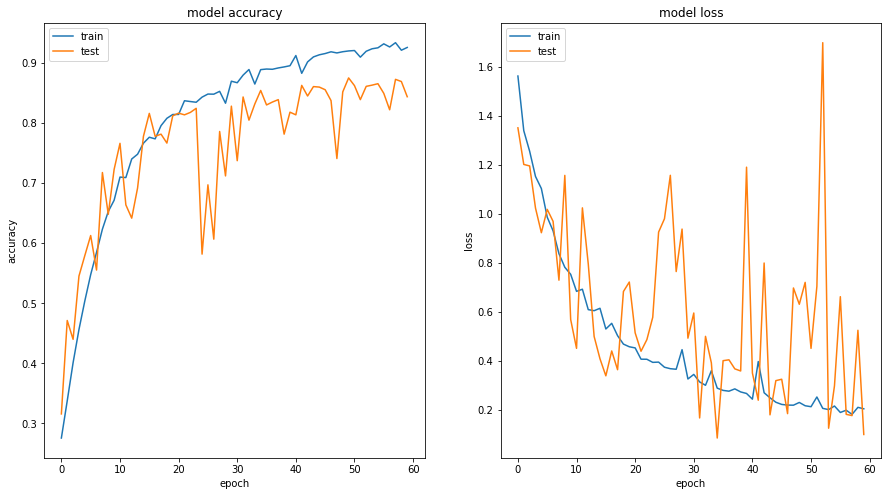

In [16]:
plot_learning_curve(hist)